<a href="https://colab.research.google.com/github/Rohit-Kavitake/Lung-Image-Segmentation-using-U-Net-Architecture/blob/main/Lung_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-processing Dataset

Loading the Required Modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
from tqdm import tqdm
import gc
import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/Data'

/content/drive/MyDrive/Colab Notebooks/Data


In [4]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
dataset_url='https://www.kaggle.com/andrewmvd/covid19-ct-scans'
od.download(dataset_url)

Skipping, found downloaded files in "./covid19-ct-scans" (use force=True to force download)


In [6]:
file_path='/content/drive/MyDrive/Colab Notebooks/Data/covid19-ct-scans/metadata.csv'

In [7]:
raw_data=pd.read_csv(file_path)
raw_data.head(4)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ct_scan                  20 non-null     object
 1   lung_mask                20 non-null     object
 2   infection_mask           20 non-null     object
 3   lung_and_infection_mask  20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


In [9]:
for x in ['ct_scan','lung_mask','infection_mask','lung_and_infection_mask']:  
  i=0
  while(i<20):
    raw_data.loc[i,x]=raw_data.loc[i,x].replace('input','Data')
    i=i+1

####The files are provided in NifTi format (*.nii) to read it we have to use the nibabel package.

In [10]:
import nibabel as nib
def read_nii(filepath):
    ni_object = nib.load(filepath)
    array   = ni_object.get_fdata()
    array   = np.rot90(np.array(array))
    return(array,ni_object)

In [11]:
ct_sample,ct_nifti   = read_nii(raw_data.loc[0,'ct_scan'])
lung_sample,lung_nifti = read_nii(raw_data.loc[0,'lung_mask'])

In [12]:
print(ct_nifti.header.get_slope_inter())

(None, None)


### Visualization and Intution of sample CT scans.

In [13]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')
    plt.show()

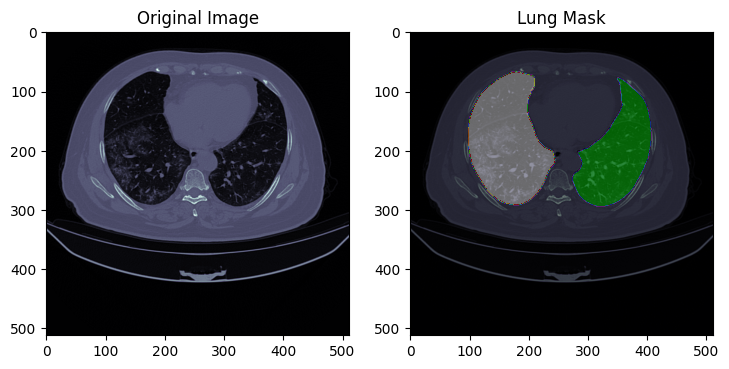

In [14]:
plot_sample([ct_sample[:,:,120], lung_sample[:,:,120]])

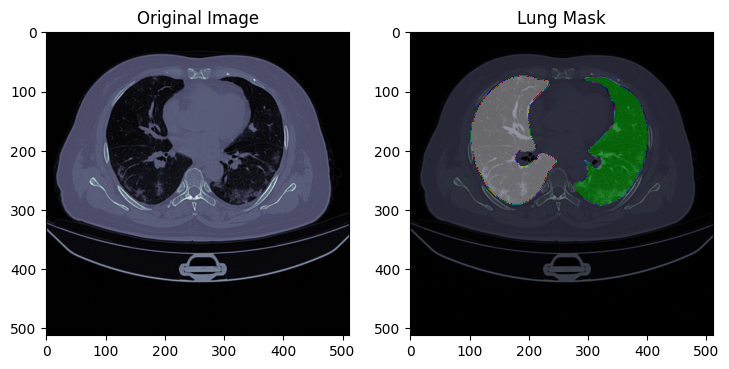

In [15]:
plot_sample([ct_sample[:,:,150], lung_sample[:,:,150]])

## Improving contract of the CT-scans


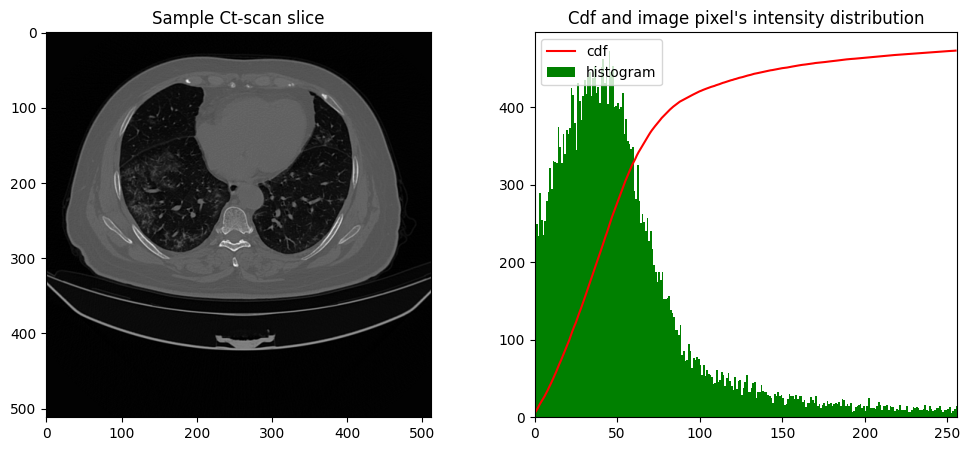

In [16]:
def plot_sample_and_hist(img,cmap='gray'):
  hist,bins = np.histogram(img.flatten(),256,[0,256])
  # here hist is the image pixel's intensity distribution
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.imshow(img,cmap=cmap)
  plt.title('Sample Ct-scan slice')

  plt.subplot(1,2,2)
  plt.hist(img.flatten(),256,[0,256], color = 'g')

  cdf=hist.cumsum()
  cdf_normalized = cdf * hist.max()/ cdf.max()

  plt.plot(cdf_normalized, color = 'r')
  plt.xlim([0,256])
  plt.legend(('cdf','histogram'), loc = 'upper left')
  plt.title("Cdf and image pixel's intensity distribution")
  plt.show()

plot_sample_and_hist(ct_sample[...,120])

#### Here Image pixel values are confined to a some specific range of values ,we need to strech its pixel's intensity distribution histogram in order to improve the image contrast .We will perform an alogorithm **contract limited adaptive historam equalization [(CLAHE)](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization)** to do so.  

In [17]:
clahe_image = cv.createCLAHE(clipLimit=7.0, tileGridSize=(8,8))
def clahe_enhancer(img, clahe, axes):
  img = np.uint8(img*255)
  clahe_img = clahe_image.apply(img)
  if len(axes) > 0 :    
    axes[0].imshow(img,cmap='gist_gray')
    axes[0].set_title("Original CT-scan Slice")
    axes[0].set_xticks([]); axes[0].set_yticks([])
 
    axes[1].imshow(clahe_img,cmap='gist_gray')
    axes[1].set_title("After appling CLAHE")
    axes[1].set_xticks([]); axes[1].set_yticks([])
 
    # Display histograms of CLAHE Enhanced Images vs Original CT Scan images
    if len(axes) > 2 :
      axes[2].hist(img.flatten(),56,[0,256], alpha=0.7, color='blue', label='Original CT-scan Slice')
      axes[2].hist(clahe_img.flatten(),56,[0,256], alpha=0.3, color='green', label="After appling CLAHE")
      axes[2].legend()
 
  return(clahe_img)

(3, 3)


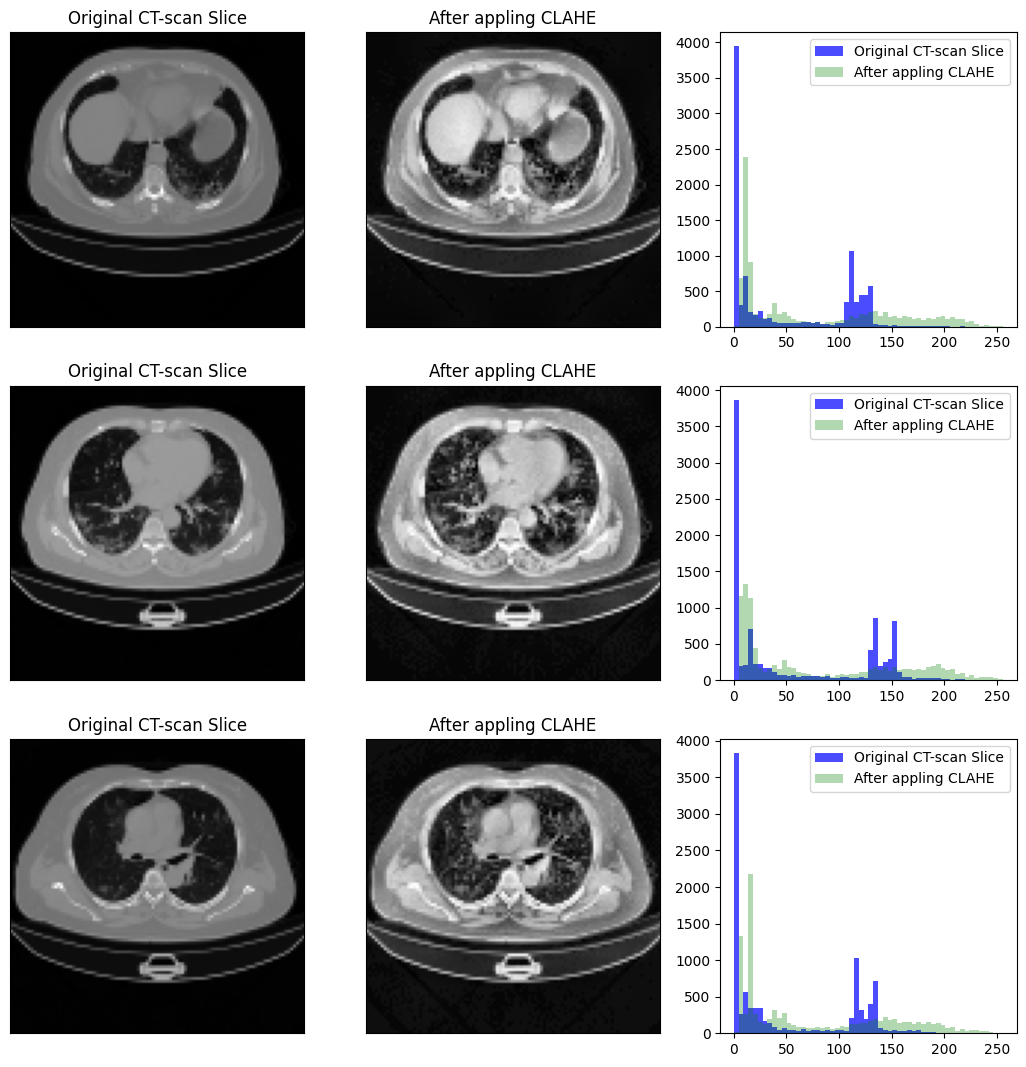

In [18]:
three_ct=ct_sample[...,np.arange(100,200,40)]
a = np.reshape(np.rollaxis(three_ct, 2),(three_ct.shape[2],three_ct.shape[0],three_ct.shape[1], 1))

fig, axes = plt.subplots(3, 3, figsize=(13,13))

for slice in range(a.shape[0]):
    img = cv.resize(a[slice], dsize=(100,100), interpolation=cv.INTER_AREA) 
    img = (img - img.min())/(img.max() - img.min())
    clahe_img = clahe_enhancer(img, clahe_image, list(axes[slice,: ])) 
print(axes.shape)    

##Cropping out the part of images ,that contain non required information

In [19]:
img_size=128
def crop_lung(img, boundaries):
  minx, miny, maxx, maxy = boundaries
  return img[miny:miny+maxy, minx:minx+maxx]

def lung_mask_crop(img, mask, show=False):
  ht, wd = mask.shape
  retval, thresh = cv.threshold(mask.astype('uint8'), 0.5, 1, 0)
  contours, hierarcy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    area=cv.contourArea(cnt)
    # print(area)
    if area>25:
      img_cnt = cv.drawContours(mask, cnt, -1, (255,255,255), 1)
  if len(contours) < 2 :
      raise Exception("Error")
  x0, y0, w0, h0 = cv.boundingRect(contours[0])
  # print(x0, y0, w0, h0)
  x1, y1, w1, h1 = cv.boundingRect(contours[1])

  B = [min(x0,x1)-round(0.05*wd), min(y0,y1)-round(0.05*ht), max(x0+w0,x1+w1)-min(x0,x1)+round(0.1*wd), 
        max(y0+h0,y1+h1)-min(y0,y1)+round(0.1*ht)]
  B = [max(B[0],0), max(B[1],0), min(B[2], wd), min(B[3], ht)]
  cct_img = crop_lung(img, B)
  rect = patches.Rectangle((B[0],B[1]),B[2],B[3],linewidth=2,edgecolor='b',facecolor='none')
  img_boundry=img.copy()
  cv.putText(img_boundry,'TO CROP',(B[0],B[1]),cv.FONT_HERSHEY_PLAIN,0.7,(0,0,255),1)

  ht, wd = img.shape
  img = (img-np.mean(img))/np.std(img)
  middle = img[int(wd/5):int(wd/5*4),int(ht/5):int(ht/5*4)] 
  mean = np.mean(middle)  
  imgmax = np.max(img)
  imgmin = np.min(img)
  img[img==imgmax]=mean
  img[img==imgmin]=mean

  
  if show:
    fig, ax = plt.subplots(1,4, figsize=[11,11])
    ax[0].set_title("CT-scan slice orignal")
    ax[0].imshow(img, cmap='bone')
    ax[0].axis('off')

    ax[1].set_title("Contours")
    ax[1].imshow(img_cnt, cmap='bone')
    ax[1].axis('off')
    
    ax[2].set_title("Bounding Box")
    ax[2].imshow(img_boundry, cmap='bone')
    ax[2].add_patch(rect)
    ax[2].axis('off')
    
    ax[3].set_title("Cropped CT-scan")
    ax[3].imshow(img, cmap='bone')
    ax[3].axis('off')
    plt.show()

  return B

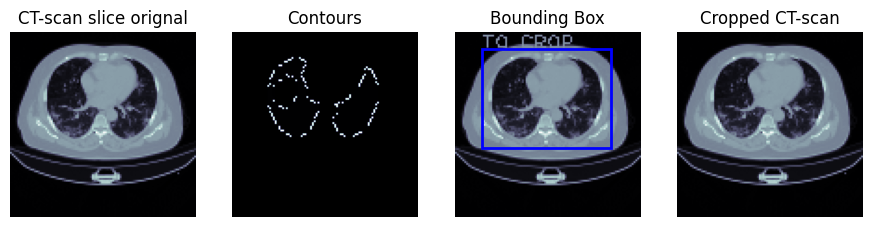

In [20]:
lung10slice=lung_sample[...,range(100,200,10)]
a_lung = np.reshape(np.rollaxis(lung10slice, 2),(lung10slice.shape[2],
                                                  lung10slice.shape[0],
                                                  lung10slice.shape[1],
                                                  1))
ct_scan_1_slice = cv.resize(a[1,...], dsize=(100, 100), interpolation=cv.INTER_AREA)
lmask_1_slice = cv.resize(a_lung[1], dsize=(100, 100), interpolation=cv.INTER_AREA)
Boundary=lung_mask_crop(ct_scan_1_slice, lmask_1_slice, show=True)

In [21]:
ct_sample[...,np.arange(100,200,20)].shape

(512, 512, 5)

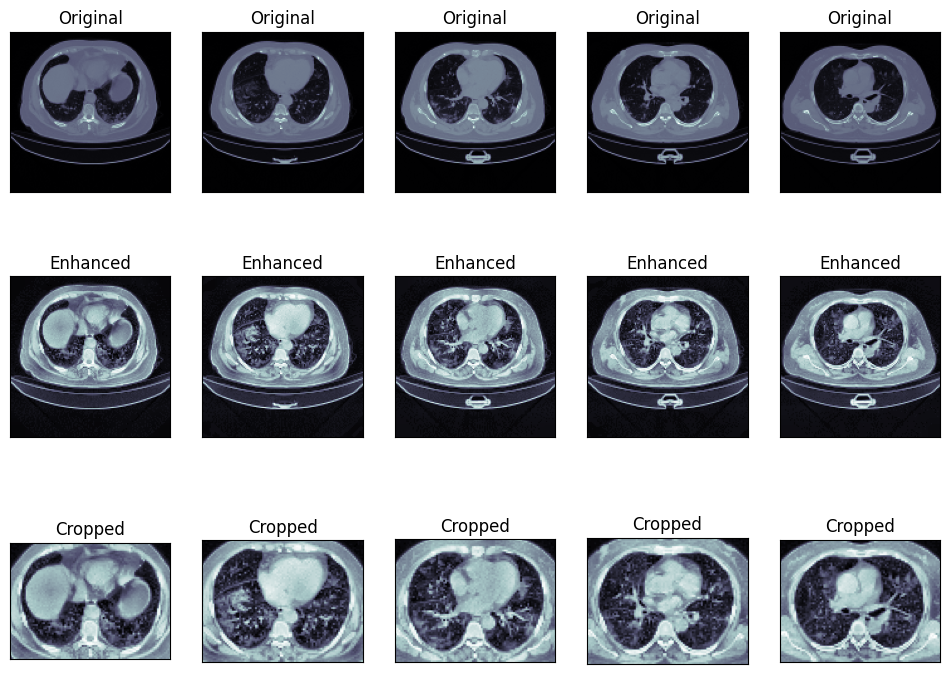

In [22]:
a=ct_sample[...,np.arange(100,200,20)]
a = np.reshape(np.rollaxis(a, 2),(a.shape[2],a.shape[0],a.shape[1], 1))

fig, axes = plt.subplots(3, 5, figsize=(12,9))


for ii in range(a.shape[0]):
    img = cv.resize(a[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    lmask = cv.resize(a_lung[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe_image, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    bounds = lung_mask_crop(img, lmask)
    cropped_img = crop_lung(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

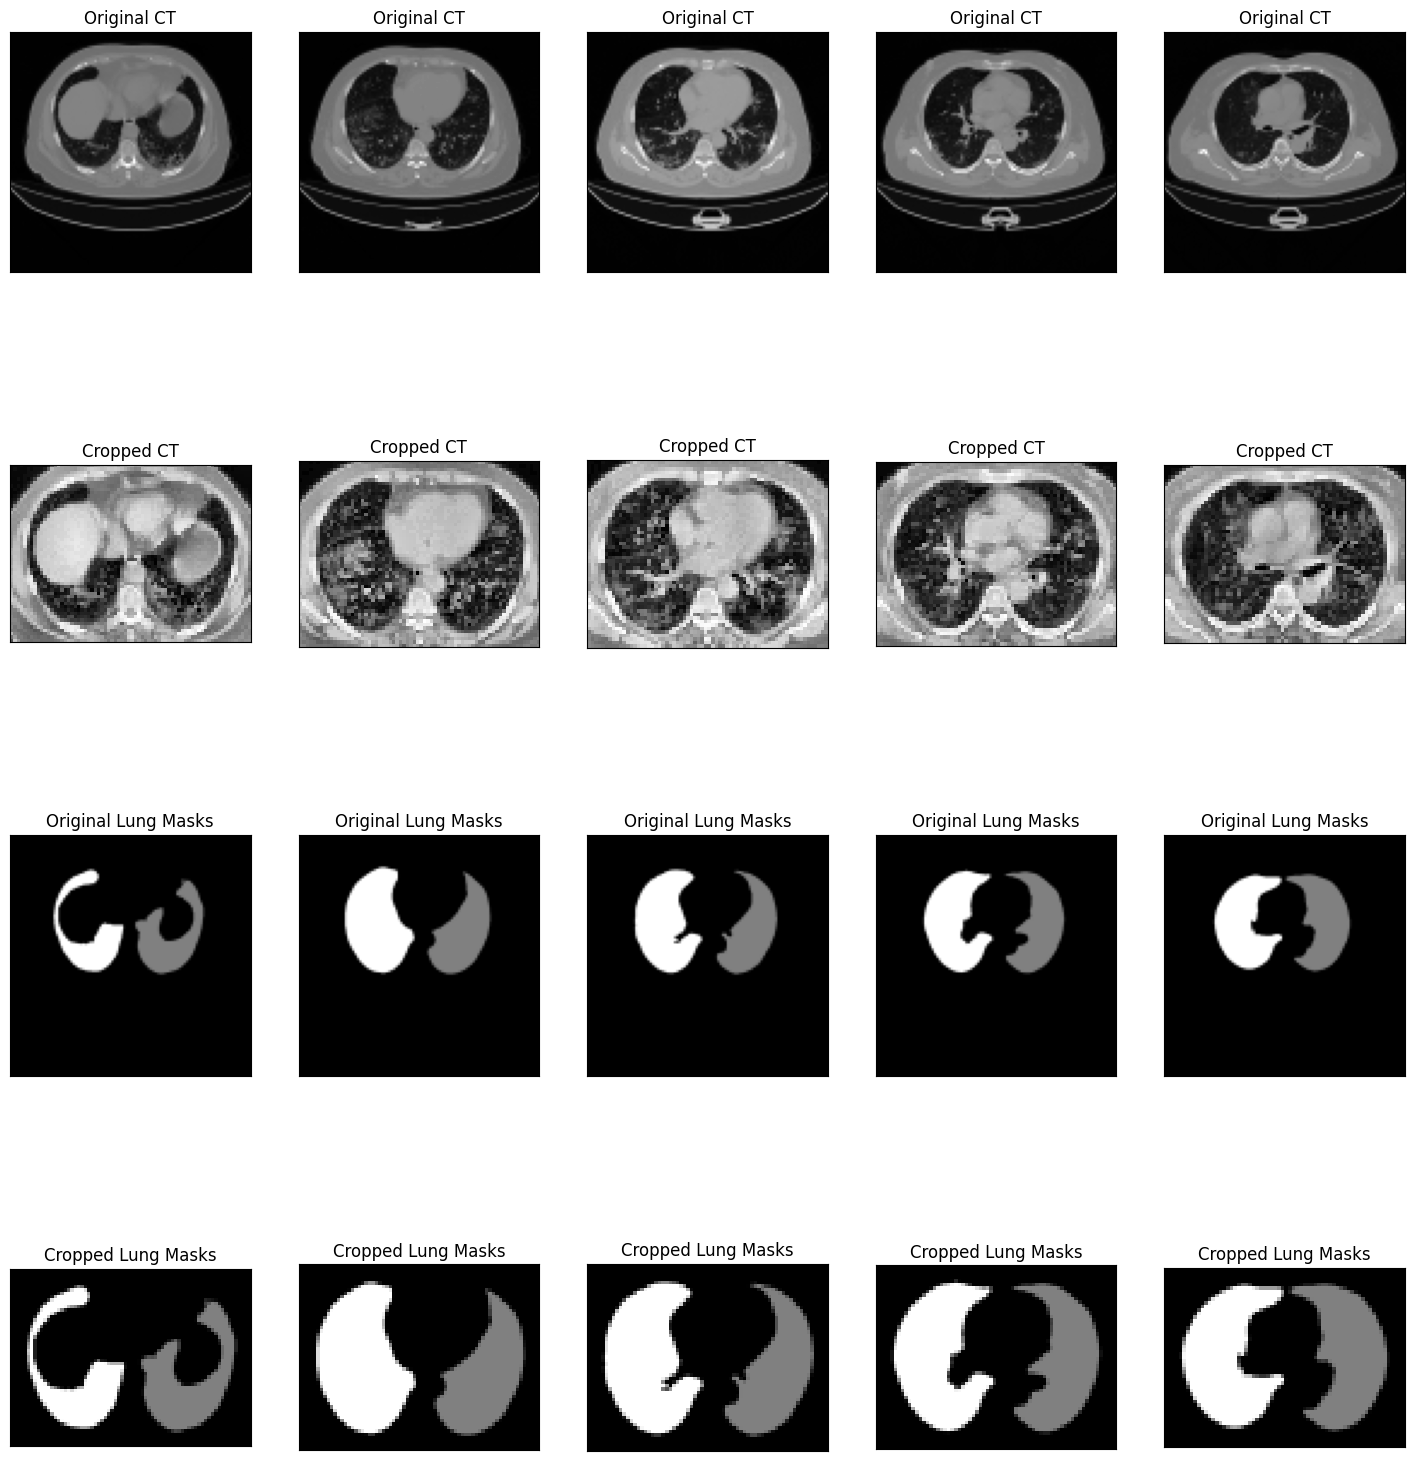

In [23]:
five_ct_slice=ct_sample[...,np.arange(100,200,20)]

five_ct_slice = np.reshape(np.rollaxis(five_ct_slice, 2),
                            (five_ct_slice.shape[2],
                             five_ct_slice.shape[0],
                             five_ct_slice.shape[1],
                             1))

# five_inf_slice=infection_sample[...,np.arange(100,200,20)]

# five_inf_slice = np.reshape(np.rollaxis(five_inf_slice, 2),
#                             (five_inf_slice.shape[2],
#                              five_inf_slice.shape[0],
#                              five_inf_slice.shape[1],
#                              1))

five_lung_sample = lung_sample[...,np.arange(100,200,20)]

five_lung_sample = np.reshape(np.rollaxis(five_lung_sample, 2),
                              (five_lung_sample.shape[2],
                               five_lung_sample.shape[0],
                               five_lung_sample.shape[1],
                               1))

fig, axes = plt.subplots(4, 5, figsize=(18,20))

for i in range (five_lung_sample.shape[0]):
  img_cts = cv.resize(five_ct_slice[i], dsize=(100, 100), interpolation=cv.INTER_AREA)
  img_lung = cv.resize(five_lung_sample[i], dsize=(100, 100), interpolation=cv.INTER_AREA)
  img_lung_o = cv.resize(five_lung_sample[i], dsize=(100, 100), interpolation=cv.INTER_AREA)
  # img_inf = cv.resize(five_inf_slice[i], dsize=(100, 100), interpolation=cv.INTER_AREA)

  img_cts = (img_cts - img_cts.min())/(img_cts.max() - img_cts.min())

  bounds = lung_mask_crop(img_cts, img_lung)

  axes[0,i].imshow(img_cts, cmap='gray')
  axes[0,i].set_title('Original CT')
  axes[0,i].set_xticks([]); axes[0,i].set_yticks([])
  
  img_cts = clahe_enhancer(img_cts, clahe_image, [])
  img_cts = crop_lung(img_cts, bounds)
  axes[1,i].imshow(img_cts, cmap='gray')
  axes[1,i].set_title('Cropped CT')
  axes[1,i].set_xticks([]); axes[1,i].set_yticks([])

  axes[2,i].imshow(img_lung_o, cmap='gray')
  axes[2,i].set_title('Original Lung Masks')
  axes[2,i].set_xticks([]); axes[2,i].set_yticks([])

  img_lung_o = crop_lung(img_lung_o, bounds)
  axes[3,i].imshow(img_lung_o, cmap='gray')
  axes[3,i].set_title('Cropped Lung Masks')
  axes[3,i].set_xticks([]); axes[3,i].set_yticks([])

###Loading all the data

In [24]:
all_cts = []
all_inf = []
all_lungs = []
bad_id = []

def nifti2arr(file_path):
  ni_object = nib.load(file_path)
  array   = ni_object.get_fdata()
  array   = np.rot90(np.array(array))
  _range = range(round(array.shape[2]*0.2), round(array.shape[2]*0.8))
  array = array[...,_range]
  array  = np.reshape(np.rollaxis(array, 2),
                     (array.shape[2],
                      array.shape[0],
                      array.shape[1],
                      1))
  return array


for i in tqdm(range(20)) :

  CT_scan  = nifti2arr(raw_data.loc[i,'ct_scan'])    
  # Infection_mask  = nifti2arr(raw_data.loc[i,'infection_mask'])
  Lung_mask  = nifti2arr(raw_data.loc[i,'lung_mask'])
  print(' ')
  print('Shape of {}th CT scan: '.format(i),CT_scan.shape)
  # print('Shape of {}th Infection mask: '.format(i),Infection_mask.shape)
  print('Shape of {}th Lung mask: '.format(i),Lung_mask.shape)
  print(' ')

  for slide in range(CT_scan.shape[0]):
    try:
      img_cts = cv.resize(CT_scan[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung = cv.resize(Lung_mask[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      img_lung_o = cv.resize(Lung_mask[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
      # img_inf = cv.resize(Infection_mask[slide], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

      xmax, xmin = img_cts.max(), img_cts.min()
      img_cts = (img_cts - xmin)/(xmax - xmin)

      bounds = lung_mask_crop(img_cts, img_lung)

      img_cts = clahe_enhancer(img_cts, clahe_image, [])
      img_cts = crop_lung(img_cts, bounds)
      all_cts.append(img_cts)

      img_lung_o = crop_lung(img_lung_o, bounds)
      all_lungs.append(img_lung_o)

      img_inf = crop_lung(img_inf, bounds)
      # all_inf.append(img_inf)
    except:
      bad_id.append(slide)
print('Total number of slides of CT-scan',len(all_cts))  
# print('Total number of slides of Infections masks',len(all_inf))   
print('Total number of slides of Lungs masks',len(all_lungs))   
print(len(bad_id))       

  0%|          | 0/20 [00:00<?, ?it/s]

 
Shape of 0th CT scan:  (181, 512, 512, 1)
Shape of 0th Lung mask:  (181, 512, 512, 1)
 


  5%|▌         | 1/20 [00:01<00:34,  1.80s/it]

 
Shape of 1th CT scan:  (120, 512, 512, 1)
Shape of 1th Lung mask:  (120, 512, 512, 1)
 


 10%|█         | 2/20 [00:07<01:14,  4.16s/it]

 
Shape of 2th CT scan:  (120, 512, 512, 1)
Shape of 2th Lung mask:  (120, 512, 512, 1)
 


 15%|█▌        | 3/20 [00:11<01:11,  4.21s/it]

 
Shape of 3th CT scan:  (162, 512, 512, 1)
Shape of 3th Lung mask:  (162, 512, 512, 1)
 


 20%|██        | 4/20 [00:19<01:28,  5.55s/it]

 
Shape of 4th CT scan:  (174, 512, 512, 1)
Shape of 4th Lung mask:  (174, 512, 512, 1)
 


 25%|██▌       | 5/20 [00:27<01:34,  6.29s/it]

 
Shape of 5th CT scan:  (127, 512, 512, 1)
Shape of 5th Lung mask:  (127, 512, 512, 1)
 


 30%|███       | 6/20 [00:35<01:38,  7.06s/it]

 
Shape of 6th CT scan:  (149, 512, 512, 1)
Shape of 6th Lung mask:  (149, 512, 512, 1)
 


 35%|███▌      | 7/20 [00:43<01:34,  7.31s/it]

 
Shape of 7th CT scan:  (181, 512, 512, 1)
Shape of 7th Lung mask:  (181, 512, 512, 1)
 


 40%|████      | 8/20 [00:51<01:31,  7.62s/it]

 
Shape of 8th CT scan:  (154, 512, 512, 1)
Shape of 8th Lung mask:  (154, 512, 512, 1)
 


 45%|████▌     | 9/20 [00:57<01:18,  7.10s/it]

 
Shape of 9th CT scan:  (181, 512, 512, 1)
Shape of 9th Lung mask:  (181, 512, 512, 1)
 


 55%|█████▌    | 11/20 [01:07<00:51,  5.74s/it]

 
Shape of 10th CT scan:  (23, 630, 630, 1)
Shape of 10th Lung mask:  (23, 630, 630, 1)
 
 
Shape of 11th CT scan:  (250, 630, 630, 1)
Shape of 11th Lung mask:  (250, 630, 630, 1)
 


 60%|██████    | 12/20 [01:21<01:04,  8.11s/it]

 
Shape of 12th CT scan:  (66, 401, 630, 1)
Shape of 12th Lung mask:  (66, 401, 630, 1)
 


 65%|██████▌   | 13/20 [01:26<00:51,  7.31s/it]

 
Shape of 13th CT scan:  (40, 630, 630, 1)
Shape of 13th Lung mask:  (40, 630, 630, 1)
 


 70%|███████   | 14/20 [01:29<00:36,  6.01s/it]

 
Shape of 14th CT scan:  (26, 630, 630, 1)
Shape of 14th Lung mask:  (26, 630, 630, 1)
 


 80%|████████  | 16/20 [01:33<00:16,  4.04s/it]

 
Shape of 15th CT scan:  (26, 630, 630, 1)
Shape of 15th Lung mask:  (26, 630, 630, 1)
 


 85%|████████▌ | 17/20 [01:36<00:10,  3.51s/it]

 
Shape of 16th CT scan:  (27, 630, 630, 1)
Shape of 16th Lung mask:  (27, 630, 630, 1)
 
 
Shape of 17th CT scan:  (55, 630, 630, 1)
Shape of 17th Lung mask:  (55, 630, 630, 1)
 


 95%|█████████▌| 19/20 [01:41<00:03,  3.14s/it]

 
Shape of 18th CT scan:  (23, 630, 630, 1)
Shape of 18th Lung mask:  (23, 630, 630, 1)
 
 
Shape of 19th CT scan:  (27, 630, 630, 1)
Shape of 19th Lung mask:  (27, 630, 630, 1)
 


100%|██████████| 20/20 [01:45<00:00,  5.26s/it]

Total number of slides of CT-scan 2063
Total number of slides of Lungs masks 2063
2112


In [25]:
del_lst = []
for i in tqdm(range(len(all_cts))) :
  try :
    all_cts[i] = cv.resize(all_cts[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_cts[i] = np.reshape(all_cts[i], (img_size, img_size, 1))
    all_lungs[i] = cv.resize(all_lungs[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    all_lungs[i] = np.reshape(all_lungs[i], (img_size, img_size, 1))
    # all_inf[i] = cv.resize(all_inf[i], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    # all_inf[i] = np.reshape(all_inf[i], (img_size, img_size, 1))
  except :
    del_lst.append(i)      

for idx in del_lst[::-1] :
  del all_cts[idx]
  del all_lungs[idx]
  # del all_inf[idx]

100%|██████████| 2063/2063 [00:00<00:00, 11660.50it/s]


In [26]:
all_cts[2060].shape

(128, 128, 1)

[]

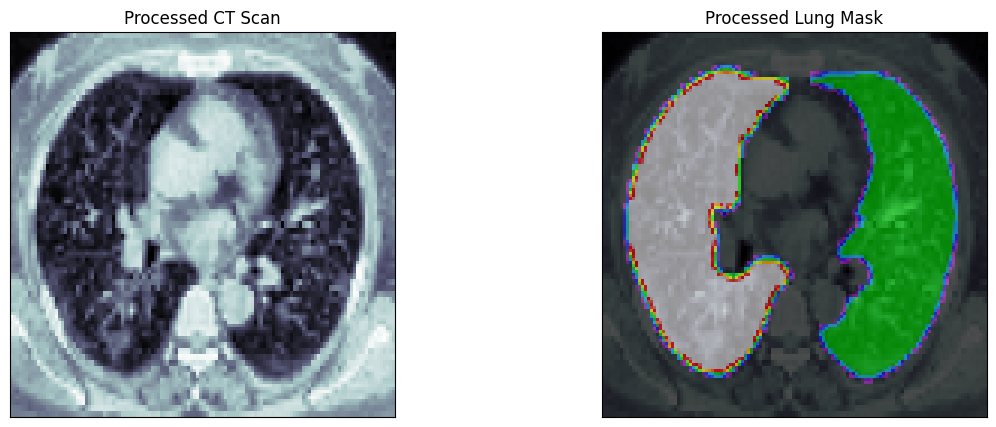

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].imshow(all_cts[100][..., 0], cmap='bone')
axes[0].set_title("Processed CT Scan")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(all_cts[100][..., 0], cmap='bone')
axes[1].imshow(all_lungs[100][..., 0],alpha=0.7 ,cmap='nipy_spectral')
axes[1].set_title("Processed Lung Mask")
axes[1].set_xticks([])
axes[1].set_yticks([])

In [28]:
with open('Processed_Data.cp', 'wb') as myfile:
    pickle.dump({'cts': all_cts, 'lungs': all_lungs}, myfile)

#Segmentation Begins

In [29]:
!ls

3d_image_segmentation.h5  covid19-ct-scans  Processed_Data.cp


In [30]:
import pandas as pd
import pickle
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import os as os
import cv2 as cv
import glob as glob
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm.notebook as tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras import callbacks
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate,add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [31]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


### Loading the preprocessed data we have saved earlier.

In [32]:
pickle_file = open("Processed_Data.cp", "rb")
objects = []
while True:
    try:
        dictionary = pickle.load(pickle_file)
        all_cts = dictionary['cts']
        all_lungs =dictionary['lungs']
        print("success")
    except EOFError:
        break
pickle_file.close()

print(objects)

success
[]


In [33]:
type(all_cts)
all_cts = np.array(all_cts)
all_lungs = np.array(all_lungs)

In [34]:
print('Total number of slides of CTscan: {}, Shape of each slide: {}'.format(all_cts.shape[0],all_cts[213].shape))

Total number of slides of CTscan: 2063, Shape of each slide: (128, 128, 1)


In [35]:
from sklearn.utils import shuffle
all_cts, all_lungs = shuffle(all_cts, all_lungs) #synchronized shuffling of data

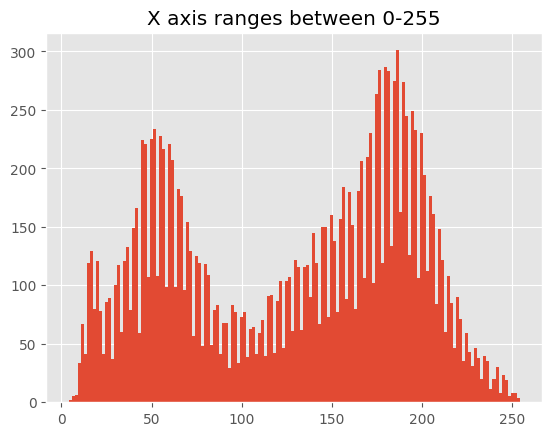

In [36]:
with plt.style.context('ggplot'):
    plt.hist(all_cts[10].flatten(),bins=150)
    plt.title('X axis ranges between 0-255')

In [37]:
all_cts = (all_cts - all_cts.min())/(all_cts.max()-all_cts.min())
all_lungs = (all_lungs - all_lungs.min())/(all_lungs.max()-all_lungs.min())
print("{} {}".format(all_cts.min(), all_cts.max()))
print("{} {}".format(all_lungs.min(), all_lungs.max()))

0.0 1.0
0.0 1.0


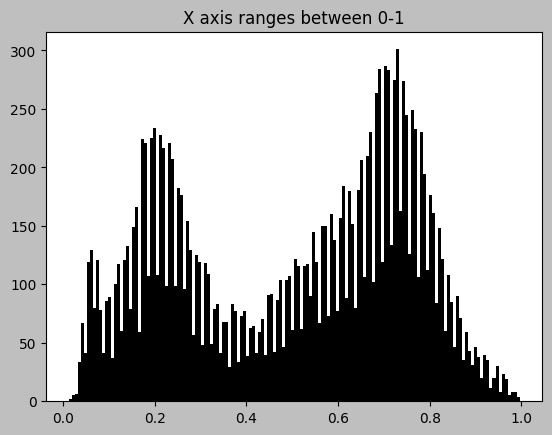

In [38]:
with plt.style.context('grayscale'):
    plt.hist(all_cts[10].flatten(),bins=150)
    plt.title('X axis ranges between 0-1')

#### We will split the dataset into training data ( 80% ), testing data( 10% ) and validation data( 10% ).

In [39]:
X_train = all_cts[:round(len(all_cts)*0.8)]
Y_train = all_lungs[:round(len(all_lungs)*0.8)]

X_val = all_cts[round(len(all_cts)*0.8):round(len(all_cts)*0.9)]
Y_val = all_lungs[round(len(all_lungs)*0.8):round(len(all_lungs)*0.9)]

X_test = all_cts[round(len(all_cts)*0.9):]
Y_test = all_lungs[round(len(all_lungs)*0.9):]

print("{} {}".format(X_train.shape, Y_train.shape))
print("{} {}".format(X_val.shape, Y_val.shape))
print("{} {}".format(X_test.shape, Y_test.shape))

(1650, 128, 128, 1) (1650, 128, 128, 1)
(207, 128, 128, 1) (207, 128, 128, 1)
(206, 128, 128, 1) (206, 128, 128, 1)


### Defining Loss and Accuracy functiton

In [40]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [41]:
im_width = 128
im_height = 128

In [42]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  """Function to add 2 convolutional layers with the parameters passed to it"""
  # first layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)
    
    # second layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)
    
  return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)
    
  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)
    
  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
  
  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  
  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  
  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  
  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [43]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [44]:

initial_learning_rate = 0.0001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss=dice_coef_loss,
    metrics=[dice_coef]
)
# checkpoint_cb = callbacks.ModelCheckpoint(
#     "3d_image_segmentation.h5", save_best_only=True
# )
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('3d_image_segmentation.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [45]:
history = model.fit(X_train, Y_train, batch_size=32, epochs = 50, validation_data = (X_val, Y_val), callbacks = callbacks,  shuffle=True)

Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: -0.5539 - dice_coef: 0.5546
Epoch 1: val_loss improved from inf to -0.61666, saving model to 3d_image_segmentation.h5
52/52 [==============================] - 33s 156ms/step - loss: -0.5539 - dice_coef: 0.5546 - val_loss: -0.6167 - val_dice_coef: 0.6169 - lr: 1.0000e-04
Epoch 2/50
51/52 [============================>.] - ETA: 0s - loss: -0.7009 - dice_coef: 0.7009
Epoch 2: val_loss did not improve from -0.61666
52/52 [==============================] - 4s 82ms/step - loss: -0.7014 - dice_coef: 0.7017 - val_loss: -0.4936 - val_dice_coef: 0.4937 - lr: 1.0000e-04
Epoch 3/50
51/52 [============================>.] - ETA: 0s - loss: -0.7393 - dice_coef: 0.7393
Epoch 3: val_loss did not improve from -0.61666
52/52 [==============================] - 4s 77ms/step - loss: -0.7394 - dice_coef: 0.7395 - val_loss: -0.3717 - val_dice_coef: 0.3714 - lr: 1.0000e-04
Epoch 4/50
51/52 [============================>.] - ETA: 0s - loss: -0.

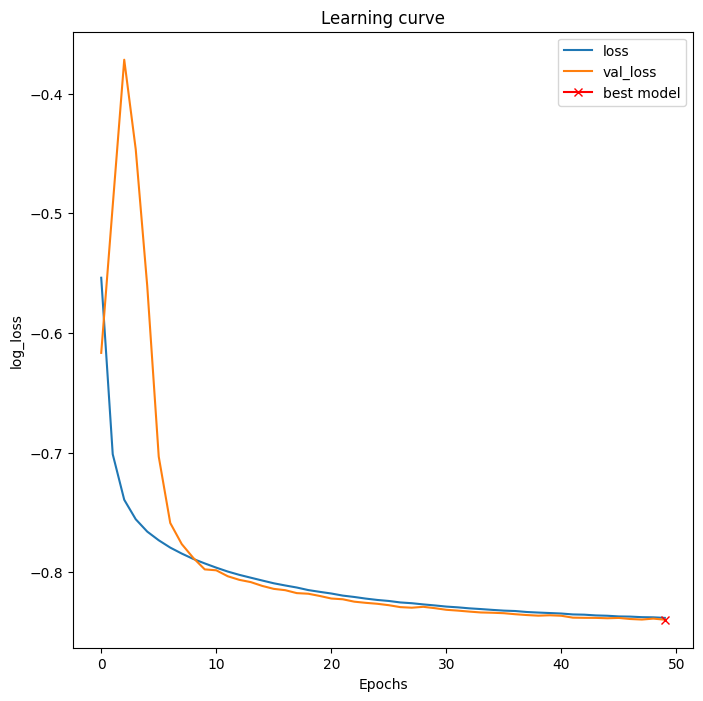

In [46]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [47]:
# load the best model
model.load_weights('3d_image_segmentation.h5')

In [48]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_val, Y_val, verbose=1)

7/7 [==============================] - 0s 26ms/step - loss: -0.8397 - dice_coef: 0.8405


[-0.8396547436714172, 0.8405175805091858]

In [49]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
prediction = model.predict(X_test)

7/7 [==============================] - 1s 104ms/step


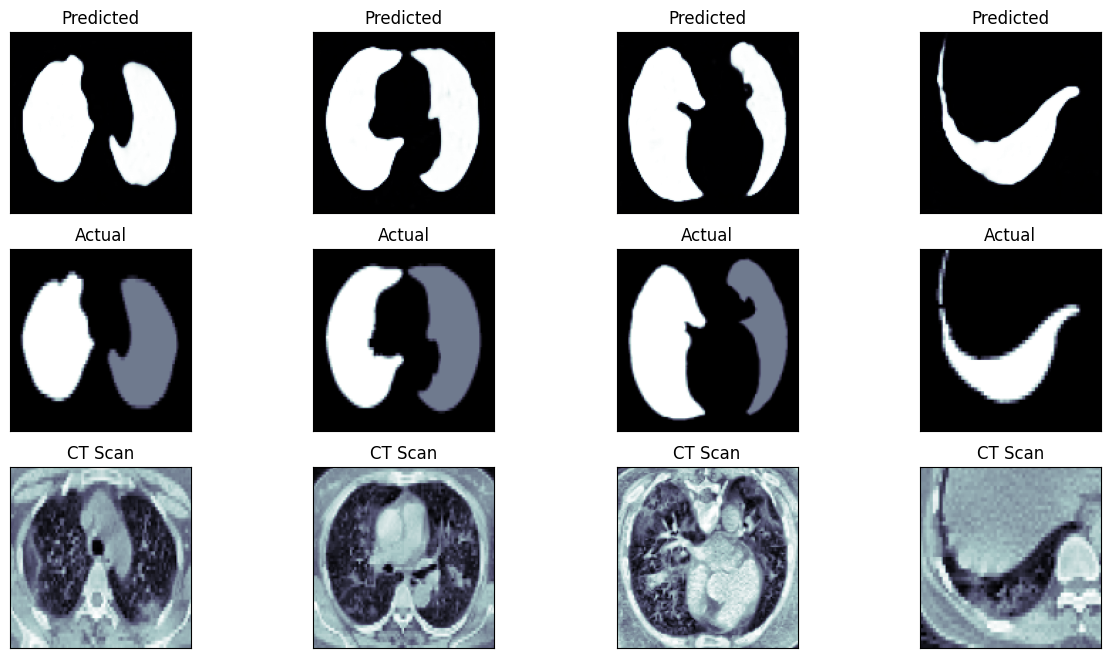

In [50]:
import random
fig, axes = plt.subplots(3, 4, figsize=(15,8))

for i in range(4):
    c = random.randint(0,prediction.shape[0]-1)
    axes[0,i].imshow(np.squeeze(prediction[c]),cmap='bone')
    axes[0,i].set_title('Predicted')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1,i].imshow(np.squeeze(Y_test[c]),cmap='bone')
    axes[1,i].set_title('Actual')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([]) 

    axes[2,i].imshow(np.squeeze(X_test[c]),cmap='bone')
    axes[2,i].set_title('CT Scan')
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])    

In [51]:
print("End of Scripts..")

End of Scripts..
